In [2]:

import boto3
# print(f"SageMaker Version: {sagemaker.__version__}")
# print(f"Installation Path: {sagemaker.__file__}")
import sagemaker
from sagemaker.pytorch import PyTorch
from io import BytesIO
from botocore.exceptions import ClientError
from PIL import Image 
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from io import StringIO

import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

import os
from scipy.stats import norm
# Get the caller identity
sts_client = boto3.client('sts')

identity = sts_client.get_caller_identity()
arn = identity['Arn']
username = arn.split('/')[-1]
import botocore
from tqdm import tqdm
import os
import time
import sys
print(f"Account: {identity['Account']}")
print(f"UserId: {identity['UserId']}")
print(f"ARN: {identity['Arn']}")
print(f"Your AWS Username is: {username}")


sagemaker.config INFO - Not applying SDK defaults from location: /Library/Application Support/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /Users/amannindra/Library/Application Support/sagemaker/config.yaml
Account: 253490779227
UserId: AIDATWBJ2KRN6C42QYYWF
ARN: arn:aws:iam::253490779227:user/amannindra2
Your AWS Username is: amannindra2


In [3]:
# REPLACE THIS STRING with the actual Role ARN you created in IAM
# role = "arn:aws:iam::253490779227:role/service-role/AmazonSageMakerAdminIAMExecutionRole" 
# boto_session = boto3.Session(region_name='us-west-1')
# sagemaker_session = sagemaker.Session(boto_session=boto_session)

# print(f"SageMaker Session Region: {sagemaker_session.boto_region_name}")
# print(f"Default Bucket: {sagemaker_session.default_bucket()}")

In [5]:
s3 = boto3.client("s3")

bucket_name = "animal-classification-dss-works"
train_folder = "preprocess/train_features"
test_folder = "preprocess/test_features"
train_features_csv = "processed/train_features.csv"
test_features_csv = "processed/test_features.csv"
train_labels_csv = "processed/train_labels.csv"

response = s3.list_objects_v2(Bucket=bucket_name)


train_labels = s3.get_object(
    Bucket=bucket_name, Key = train_labels_csv
)

content_labels = train_labels["Body"].read().decode("utf-8")
content_labels = StringIO(content_labels)
df_labels = pd.read_csv(content_labels)
df_labels


,id,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
0,ZJ000000,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ZJ000001,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,ZJ000002,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ZJ000003,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,ZJ000004,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
16483,ZJ016483,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
16484,ZJ016484,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16485,ZJ016485,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
16486,ZJ016486,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
col = df_labels.columns
print(type(col), col)
col = col.drop(col[0])
print(col)

<class 'pandas.core.indexes.base.Index'> Index(['id', 'antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog',
       'leopard', 'monkey_prosimian', 'rodent'],
      dtype='object')
Index(['antelope_duiker', 'bird', 'blank', 'civet_genet', 'hog', 'leopard',
       'monkey_prosimian', 'rodent'],
      dtype='object')


In [7]:
count = {}

for i in col:
    count[i] = len(df_labels[df_labels[i] == 1.0])
    print(f"There are {count[i]} images of {i}")
count


There are 2474 images of antelope_duiker
There are 1641 images of bird
There are 2213 images of blank
There are 2423 images of civet_genet
There are 978 images of hog
There are 2254 images of leopard
There are 2492 images of monkey_prosimian
There are 2013 images of rodent


{'antelope_duiker': 2474,
 'bird': 1641,
 'blank': 2213,
 'civet_genet': 2423,
 'hog': 978,
 'leopard': 2254,
 'monkey_prosimian': 2492,
 'rodent': 2013}

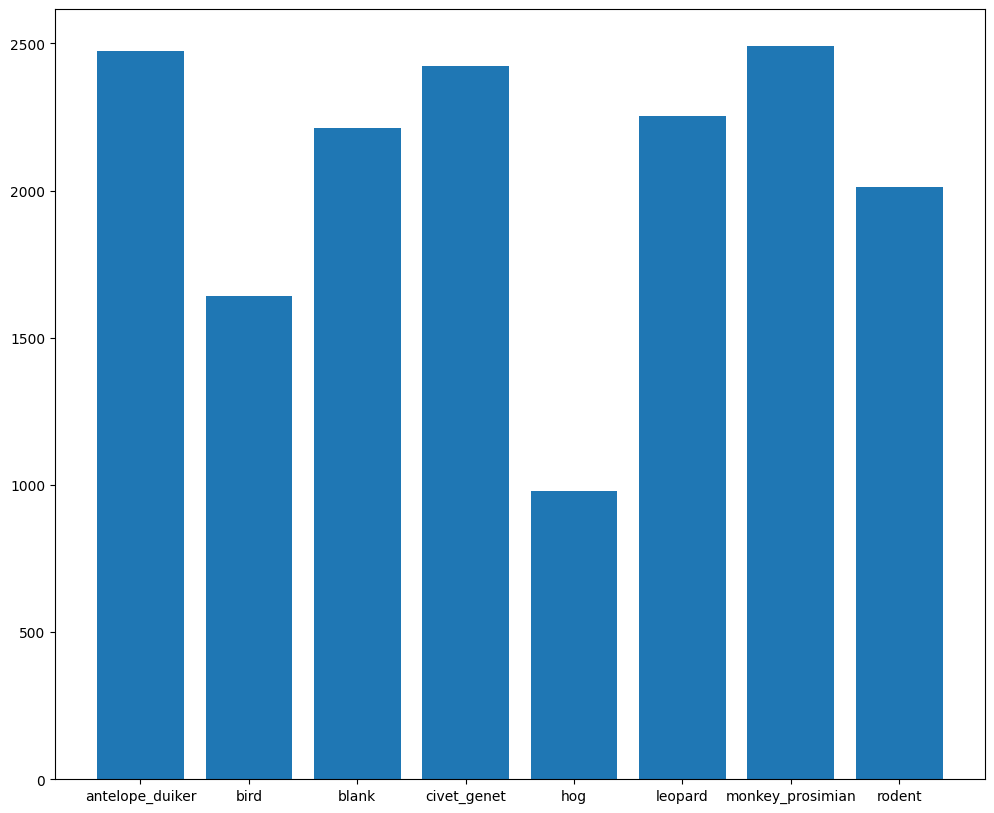

In [8]:
fig, ax = plt.subplots(figsize=(12, 10))

plt.bar(count.keys(), count.values())
plt.show()


In [9]:
train_features = s3.get_object(
    Bucket=bucket_name, Key = train_features_csv
)
content_features = train_features["Body"].read().decode("utf-8")
content_features = StringIO(content_features)
df_features = pd.read_csv(content_features)
df_features



,id,filepath,site
0,ZJ000000,train_features/ZJ000000.jpg,S0120
1,ZJ000001,train_features/ZJ000001.jpg,S0069
2,ZJ000002,train_features/ZJ000002.jpg,S0009
3,ZJ000003,train_features/ZJ000003.jpg,S0008
4,ZJ000004,train_features/ZJ000004.jpg,S0036
...,...,...,...
16483,ZJ016483,train_features/ZJ016483.jpg,S0093
16484,ZJ016484,train_features/ZJ016484.jpg,S0043
16485,ZJ016485,train_features/ZJ016485.jpg,S0089
16486,ZJ016486,train_features/ZJ016486.jpg,S0095


In [10]:
test_features = s3.get_object(
    Bucket=bucket_name, Key = test_features_csv
)
content_test_features = test_features["Body"].read().decode("utf-8")
content_test_features = StringIO(content_test_features)
df_test_features = pd.read_csv(content_test_features)
df_test_features


,id,filepath,site
0,ZJ016488,test_features/ZJ016488.jpg,S0082
1,ZJ016489,test_features/ZJ016489.jpg,S0040
2,ZJ016490,test_features/ZJ016490.jpg,S0040
3,ZJ016491,test_features/ZJ016491.jpg,S0041
4,ZJ016492,test_features/ZJ016492.jpg,S0040
...,...,...,...
4459,ZJ020947,test_features/ZJ020947.jpg,S0086
4460,ZJ020948,test_features/ZJ020948.jpg,S0152
4461,ZJ020949,test_features/ZJ020949.jpg,S0162
4462,ZJ020950,test_features/ZJ020950.jpg,S0055


In [11]:
# s3://animal-classification-dss-works/data/train_features/ZJ000000.jpg

# def get_image_keys_with_paginator(bucket, prefix):
#     """Get all image keys using boto3 paginator"""
#     image_keys = []
    
#     # Create paginator
#     paginator = s3.get_paginator('list_objects_v2')
#     pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
    
#     # Iterate through all pages
#     for page in pages:
#         for obj in page.get('Contents', []):
#             key = obj['Key']
#             if key.lower().endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
#                 image_keys.append(key)
    
#     return image_keys

# def get_image_array(image_key: str) -> np.ndarray:
#     # image_key = os.path.join(train_folder, image_key)
#     image_obj = s3.get_object(
#         Bucket=bucket_name, Key = image_key
#     )
#     image_data = image_obj["Body"].read()
#     image = Image.open(BytesIO(image_data))
#     return np.array(image)


# def get_image_size(image_key: str) -> tuple[int, int]:
#     image_obj = s3.get_object(
#         Bucket=bucket_name, Key = image_key
#     )
#     image_data = image_obj["Body"].read()
#     image = Image.open(BytesIO(image_data))
#     return image.size


# def get_image_(image_key: str) -> bool:
#     image_obj = s3.get_object(
#         Bucket=bucket_name, Key = image_key
#     )
#     image_data = image_obj["Body"].read()
#     image = Image.open(BytesIO(image_data))
#     return [image.mode == 'RGB', image.size]

def get_image_from_s3(key):
    """Get image from S3 without downloading to disk"""
    try:
        key = os.path.join("data", key)
        response = s3.get_object(Bucket=bucket_name, Key=key)
        image = Image.open(BytesIO(response["Body"].read()))
        return image
    except Exception as e:
        print(f"Error loading, {e}")
        return None


train_keys = df_features['filepath']
print(train_keys[:5])

count_rgb = 0
count_grayscale = 0
size = []
for i in range(1000):
    try:
        image = get_image_from_s3(train_keys[i])
        size.append(image.size)
        if image.mode == 'RGB':
            count_rgb += 1
        else:
            count_grayscale += 1
    except Exception as e:
        print(f"Error: {e}")
        print(f"Image key: {train_keys[i]}")
    if i % 100 == 0:
        print(i)
print(f"RGB: {count_rgb}")
print(f"GRAYSCALE: {count_grayscale}")
print(f"There are {count_rgb/1000:.2f}% of RGB images")
print(f"There are {count_grayscale/1000:.2f}% of GRAYSCALE images")

print(size[:20])




# image_key = "ZJ000000.jpg"

# train_images = get_image_keys_with_paginator(bucket_name, 'data/test_features/')
# print(train_images)
# image_array = []
# print(f"length: {len(train_images)}")
# for i in range(len(train_images)):
#     image_array.append(get_image_array(train_images[i]))
#     if i % 100 == 0:
#         print(i)
    

# print(len(image_array))
# print(image_array)




0    train_features/ZJ000000.jpg
1    train_features/ZJ000001.jpg
2    train_features/ZJ000002.jpg
3    train_features/ZJ000003.jpg
4    train_features/ZJ000004.jpg
Name: filepath, dtype: object
0
100
200
300
400
500
600
700
800
900
RGB: 876
GRAYSCALE: 124
There are 0.88% of RGB images
There are 0.12% of GRAYSCALE images
[(960, 540), (960, 540), (640, 360), (640, 360), (640, 335), (960, 540), (960, 540), (640, 360), (960, 540), (960, 515), (640, 335), (640, 360), (160, 120), (960, 540), (640, 360), (640, 360), (360, 215), (160, 120), (360, 240), (640, 360)]


In [12]:
size

[(960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 335),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 515),
 (640, 335),
 (640, 360),
 (160, 120),
 (960, 540),
 (640, 360),
 (640, 360),
 (360, 215),
 (160, 120),
 (360, 240),
 (640, 360),
 (360, 215),
 (960, 540),
 (640, 360),
 (960, 515),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (360, 240),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (360, 240),
 (360, 240),
 (960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 360),
 (640, 360),
 (960, 540),
 (960, 540),
 (640, 360),
 (360, 240),
 (960, 515),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),
 (640, 360),
 (640, 360),
 (640, 360),
 (640, 360),
 (960, 540),
 (640, 335),
 (640, 360),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (640, 360),
 (960, 540),
 (960, 540),

In [13]:
width, height = [], []
for i in range(len(size)):
    width.append(size[i][0])
    height.append(size[i][1])
width = np.array(width)
height = np.array(height)


In [14]:
print(f"Width: {width.mean()}, Height: {height.mean()}")
print(f"Width: {width.std()}, Height: {height.std()}")
print(f"Width: {width.min()}, Height: {height.min()}")
print(f"Width: {width.max()}, Height: {height.max()}")


Width: 741.72, Height: 417.47
Width: 199.00613457881138, Height: 107.10251677715141
Width: 160, Height: 120
Width: 960, Height: 540


In [15]:
print(np.unique(width,return_counts=True))
print(f"most common width: {np.argmax(np.bincount(width))} with count {np.max(np.bincount(width))}")
print(np.unique(height,return_counts=True))
print(f"most common height: {np.argmax(np.bincount(height))} with count {np.max(np.bincount(height))}")

(array([160, 360, 640, 960]), array([ 23,  51, 529, 397]))
most common width: 640 with count 529
(array([120, 215, 240, 335, 360, 515, 540]), array([ 23,   6,  45,  61, 468,  27, 370]))
most common height: 360 with count 468


In [16]:
count

{'antelope_duiker': 2474,
 'bird': 1641,
 'blank': 2213,
 'civet_genet': 2423,
 'hog': 978,
 'leopard': 2254,
 'monkey_prosimian': 2492,
 'rodent': 2013}

In [17]:
train_folder

'preprocess/train_features'

In [18]:
# fig, axes = plt.subplots(len(count), 5, figsize=(15, 3*len(count)))
# fig.suptitle('Sample Images per Class', fontsize=16, fontweight='bold')

# for i, (class_name, num_samples) in enumerate(count.items()):
#     # Get 5 random samples from this class
#     class_samples = df_labels[df_labels[class_name] == 1].sample(min(5, num_samples))
    
#     for j, (idx, row) in enumerate(class_samples.iterrows()):
#         img_path = os.path.join(train_folder, row['id'] + ".jpg")
#         print(img_path)
#         image = get_image_from_s3(img_path)
        
#         if image is None:
#             print(f"Error loading image: {img_path}")
#             continue
        
#         print(type(image))
#         axes[i, j].imshow(image)
#         axes[i, j].axis('off')
#         if j == 0:
#             axes[i, j].set_ylabel(class_name, fontsize=10, rotation=0, ha='right')

# plt.show()

1000
1000



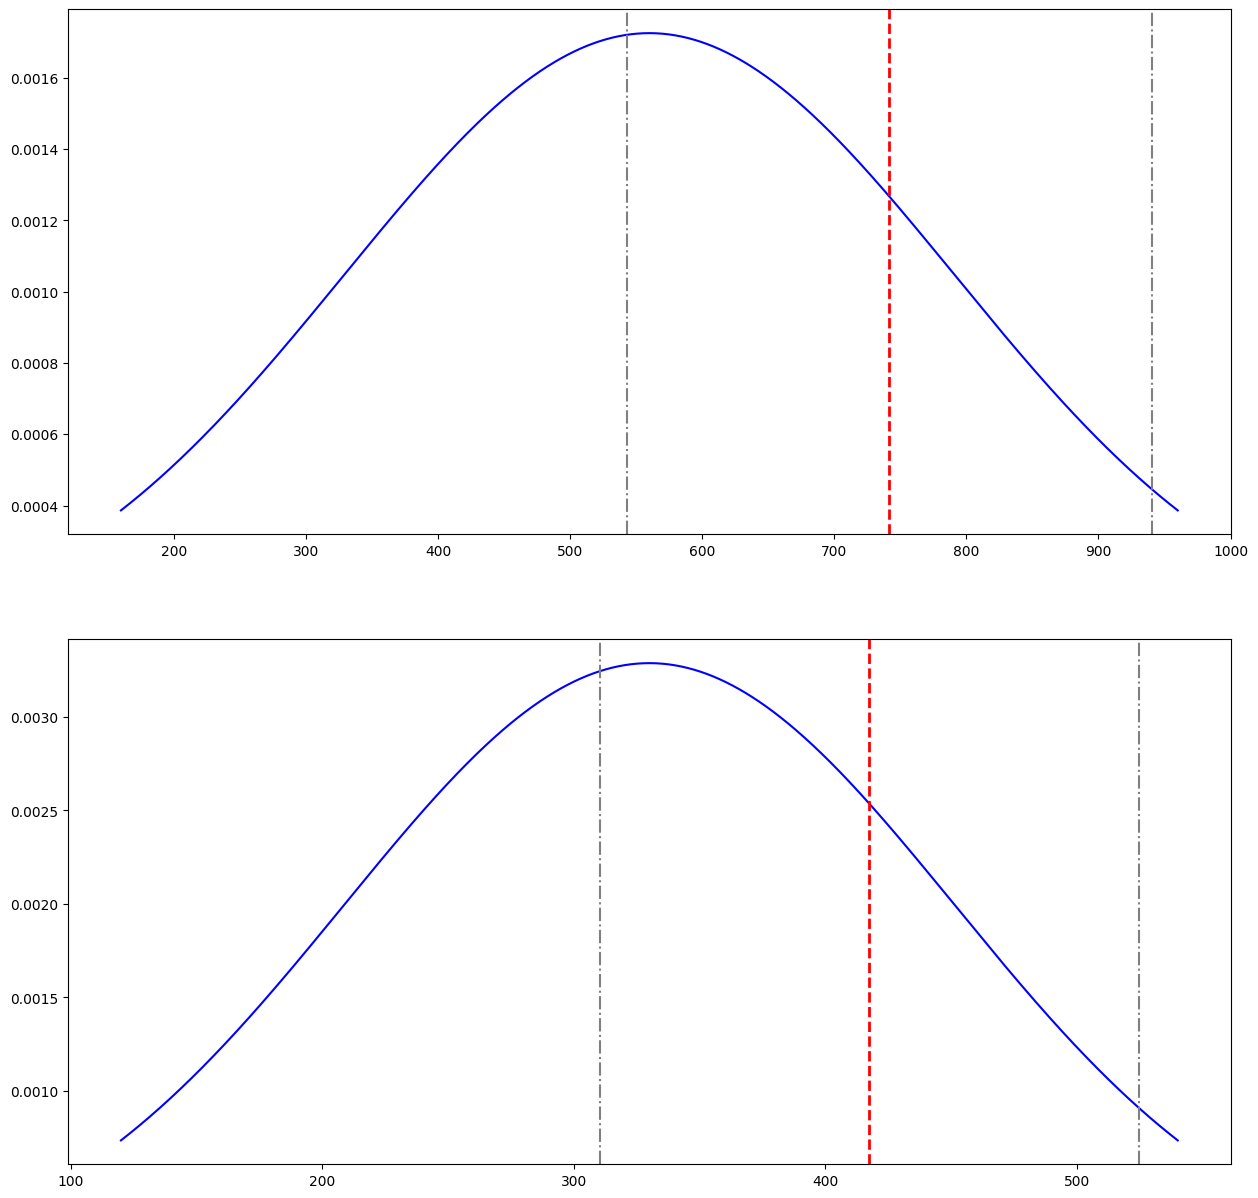

In [19]:
mean = 0
std_dev = 1


def pdf(x):
    mean = x.mean()
    std_dev = x.std()
    return (1 / (std_dev * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mean) / std_dev) ** 2)


x_width = np.linspace(width.min(), width.max(), 1000)
x_height = np.linspace(height.min(), height.max(), 1000)

y_width = pdf(x_width)
y_height = pdf(x_height)
print(len(y_width))
print(len(y_height))

print()


fig, ax1 = plt.subplots(2, 1, figsize=(15, 15))



ax1[0].plot(x_width, y_width, 'b-', label='Normal Distribution')
ax1[1].plot(x_height , y_height, 'b-', label='Normal Distribution')

mean_w, std_w = width.mean(), width.std()
mean_h, std_h = height.mean(), height.std()

ax1[0].axvline(mean_w, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_w:.1f}')
ax1[0].axvline(mean_w + std_w, color='gray', linestyle='-.', label=f'±1 STD: {std_w:.1f}')
ax1[0].axvline(mean_w - std_w, color='gray', linestyle='-.')

ax1[1].axvline(mean_h, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_h:.1f}')
ax1[1].axvline(mean_h + std_h, color='gray', linestyle='-.', label=f'±1 STD: {std_h:.1f}')
ax1[1].axvline(mean_h - std_h, color='gray', linestyle='-.')

# ax1[0].hist(width, bins=50, density=True, alpha=0.6, color='lightblue', edgecolor='black')
# ax1[0].plot(x_width, y_width, 'r-', linewidth=2, label='PDF')

# ax1[1].hist(height, bins=50, density=True, alpha=0.6, color='lightgreen', edgecolor='black')
# ax1[1].plot(x_height, y_height, 'r-', linewidth=2, label='PDF')



# ax1.plot(x, y, 'b-', label='Normal Distribution')

# # Add vertical lines to show mean and standard deviations
# ax1.axvline(mean, color='r', linestyle='--', label='Mean')
# plt.axvline(mean + std_dev, color='gray', linestyle='-.', label='±1 STD')
# plt.axvline(mean - std_dev, color='gray', linestyle='-.')

# plt.xlabel('X')
# plt.ylabel('Probability Density')
# plt.title('Normal Distribution with Standard Deviations')
# plt.legend()
# plt.grid(True)
# plt.show()

In [20]:
test_keys = df_test_features['filepath']
test_keys[:5]

0    test_features/ZJ016488.jpg
1    test_features/ZJ016489.jpg
2    test_features/ZJ016490.jpg
3    test_features/ZJ016491.jpg
4    test_features/ZJ016492.jpg
Name: filepath, dtype: object

In [21]:
unique_sizes = list(set(size))
print(len(unique_sizes))
print(unique_sizes)



7
[(160, 120), (960, 515), (640, 335), (960, 540), (640, 360), (360, 215), (360, 240)]


In [22]:
train_keys[0]

'train_features/ZJ000000.jpg'

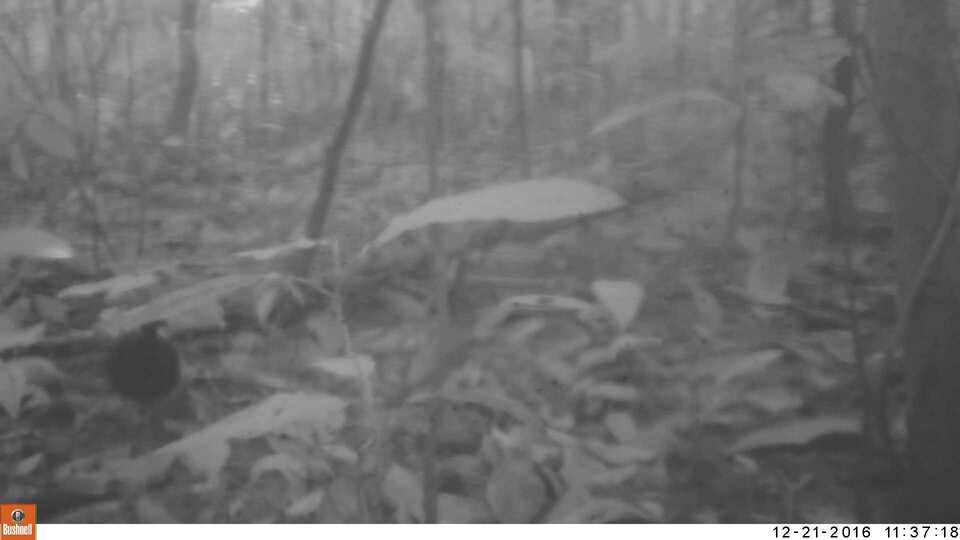

In [23]:

image = get_image_from_s3(train_keys[0])
image2 = get_image_from_s3(train_keys[1])
image

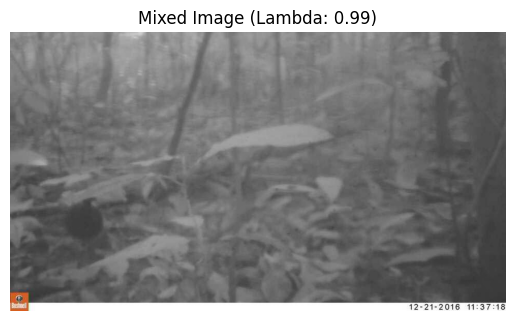

In [24]:
img1 = np.array(image)
img2 = np.array(image2)

# Ensure images are of type float for precise mixing
img1 = img1.astype(np.float32)
img2 = img2.astype(np.float32)

lambda_val = np.random.beta(0.4, 0.4)

mixed_image_np = (lambda_val * img1) + ((1 - lambda_val) * img2)

# Ensure the final array is clipped to valid pixel values (0-255) and cast back to uint8
mixed_image_np = np.clip(mixed_image_np, 0, 255).astype(np.uint8)

plt.imshow(mixed_image_np)
plt.axis('off') # Optional: hides axes and ticks for a cleaner look
plt.title(f"Mixed Image (Lambda: {lambda_val:.2f})")
plt.show()

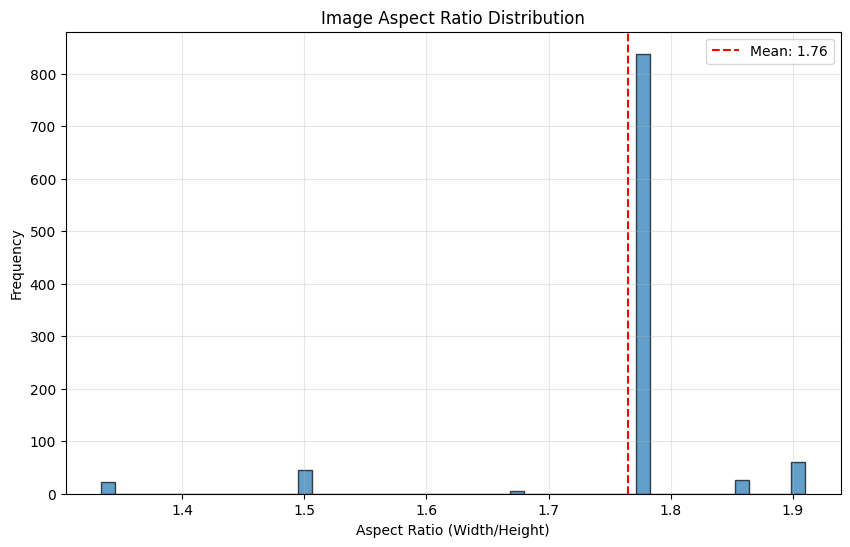

Aspect ratio stats:
  Min: 1.33
  Max: 1.91
  Mean: 1.76
  Std: 0.10


In [25]:
# After you create width and height arrays
aspect_ratios = width / height
plt.figure(figsize=(10, 6))
plt.hist(aspect_ratios, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Aspect Ratio (Width/Height)')
plt.ylabel('Frequency')
plt.title('Image Aspect Ratio Distribution')
plt.axvline(aspect_ratios.mean(), color='red', linestyle='--', label=f'Mean: {aspect_ratios.mean():.2f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Aspect ratio stats:")
print(f"  Min: {aspect_ratios.min():.2f}")
print(f"  Max: {aspect_ratios.max():.2f}")
print(f"  Mean: {aspect_ratios.mean():.2f}")
print(f"  Std: {aspect_ratios.std():.2f}")

In [29]:
import torch
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, df, class_cols, transform=None):
        self.df = df.reset_index(drop=True)
        self.class_cols = class_cols
        self.transform = transform

        # Precompute integer labels
        y = self.df[self.class_cols].values
        assert (y.sum(axis=1) == 1).all()
        self.labels = y.argmax(axis=1).astype("int64")

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # load image however you do it
        img = ...  
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)  # scalar
        return img, label
    def get_y(self):
        return self.labels
    

dataset = MyDataset(df_labels, col)



array([1, 6, 1, 6, 5, 4, 3, 0, 5, 1, 5, 5, 6, 2, 6, 2, 5, 1, 2, 6, 5, 6,
       0, 5, 6, 7, 6, 6, 6, 2, 0, 6, 4, 3, 6, 7, 3, 0, 6, 0, 3, 2, 5, 0,
       3, 2, 5, 6, 6, 0, 7, 2, 4, 5, 7, 6, 3, 0, 6, 6, 1, 2, 2, 5, 2, 0,
       3, 0, 7, 3, 2, 1, 4, 3, 1, 3, 7, 3, 0, 1, 6, 1, 2, 3, 2, 3, 5, 1,
       0, 6, 5, 2, 1, 3, 0, 7, 5, 5, 0, 5, 2, 0, 5, 6, 2, 6, 5, 2, 5, 4,
       2, 0, 7, 3, 1, 3, 3, 6, 7, 5, 6, 6, 7, 0, 0, 1, 7, 0, 5, 1, 7, 0,
       3, 3, 4, 3, 3, 0, 5, 3, 0, 2, 2, 7, 2, 0, 7, 7, 7, 0, 0, 3, 0, 7,
       1, 2, 5, 0, 3, 5, 7, 5, 1, 1, 6, 2, 5, 1, 2, 7, 0, 6, 2, 6, 1, 5,
       3, 6, 3, 5, 2, 2, 6, 6, 7, 5, 3, 0, 0, 5, 1, 0, 1, 2, 6, 2, 2, 0,
       7, 6, 2, 6, 3, 7, 2, 7, 7, 0, 1, 7, 0, 0, 7, 5, 6, 6, 0, 7, 3, 7,
       4, 2, 0, 7, 3, 7, 7, 6, 0, 5, 6, 1, 2, 6, 3, 5, 5, 5, 0, 0, 3, 2,
       3, 7, 5, 1, 6, 0, 6, 6, 7, 1, 2, 5, 0, 6, 7, 2, 3, 5, 6, 6, 7, 0,
       6, 6, 1, 2, 7, 3, 0, 7, 7, 0, 5, 0, 2, 1, 3, 5, 2, 0, 7, 3, 1, 4,
       2, 7, 7, 0, 7, 6, 1, 5, 7, 2, 5, 6, 2, 6, 3,